In [1]:
import numpy as np

# Establish Pisces baseline by loading data, making triplots

In [2]:

from analyses.NHRC.nhrc_utils.analysis import DEFAULT_EVALUATION_DIR, SCENARIOS, STATIONARY_LOWER, HYBRID_LOWER
import matplotlib.pyplot as plt
from analyses.NHRC.nhrc_utils.analysis import ACCURACY_COLUMN, AUROC_COLUMN, MODEL_COLUMN, SCENARIO_COLUMN, SLEEP_ACCURACY_COLUMN, WASA_COLUMN
from analyses.NHRC.nhrc_utils.plotting import tri_plot_metrics
from analyses.NHRC.nhrc_utils.model_definitions import EXTRA_LAYERS_NAME, EXTRA_LOWER, LR_LOWER, NAIVE_LOWER


WASA_SLEEP_PERCENT = 95
STATIONARY_SET_NAME = "Stationary Data"
HYBRID_SET_NAME = "Hybrid Data"
SECOND_LINE = f"Sleep Accuracy ≈ {WASA_SLEEP_PERCENT}%"
SECOND_TITLE_LINE = f"Comparison of Stationary and Hybrid Data Metrics, {SECOND_LINE}"
TRIPLOT_DPI = 300

scenarios = SCENARIOS

LR_KERNEL_SIZE: 61


In [3]:
from collections import defaultdict
from analyses.NHRC.nhrc_utils.analysis import prepare_data

sets_prepro_data = defaultdict(dict)

acc_hz_string = "dyn"

for set_name in scenarios:
    print("Loading", set_name)
    sets_prepro_data[set_name] = np.load(f'./pre_processed_data/{set_name}/{set_name}_preprocessed_data_{acc_hz_string}.npy', allow_pickle=True).item()

walch_data_bundle = prepare_data(sets_prepro_data['stationary'])
hybrid_data_bundle = prepare_data(sets_prepro_data['hybrid'])

Loading stationary
Loading hybrid
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


In [4]:

import pandas as pd
import tensorflow as tf
from analyses.NHRC.nhrc_utils.analysis import DF_COLUMNS, WASA_SLEEP_ACCURACY, auroc_balaccuracy_wasa
from analyses.NHRC.nhrc_utils.model_definitions import cnn_pred_proba, lr_cnn_pred_proba, naive_pred_proba


# rev_sets = reverse_dicts(rev_sets_prepro)
walch_keys = list(sets_prepro_data['stationary'].keys())

cnn_predictors = [
    tf.keras.models.load_model(f"/Users/eric/Engineering/Work/pisces/analyses/NHRC/evaluations/models/finetuning_{i}.keras")
    for i in walch_keys 
]

lr_predictors = [
    tf.keras.models.load_model(f"/Users/eric/Engineering/Work/pisces/analyses/NHRC/evaluations/models/lr_{i}.keras")
    for i in walch_keys 
]

model_types = ['naive', 'finetuning', 'lr']

evals = {s: 
    {m: [] for m in model_types} 
    for s in scenarios 
}

evaluations_df = pd.DataFrame(columns=DF_COLUMNS)

for test_idx in range(len(walch_keys)):
    # extract inputs
    stationary_weights = walch_data_bundle.sample_weights[test_idx].numpy()
    stationary_labels = walch_data_bundle.true_labels[test_idx].numpy()
    stationary_labels_masked = np.where(stationary_weights, stationary_labels, 0)
    stationary_wldm_predictions = walch_data_bundle.mo_predictions[test_idx].numpy()
    stationary_lr_input = walch_data_bundle.activity[test_idx].numpy()

    hybrid_wldm_predictions = hybrid_data_bundle.mo_predictions[test_idx].numpy()
    hybrid_lr_input = hybrid_data_bundle.activity[test_idx].numpy()

    # z-normalize input data
    stationary_lr_input = (stationary_lr_input - np.mean(stationary_lr_input)) / np.std(stationary_lr_input)
    hybrid_lr_input = (hybrid_lr_input - np.mean(hybrid_lr_input)) / np.std(hybrid_lr_input)


    # process inputs into predictions
    stationary_naive = naive_pred_proba(stationary_wldm_predictions)
    stationary_lr = lr_cnn_pred_proba(
            lr_predictors[test_idx], 
            stationary_lr_input)
    stationary_cnn = cnn_pred_proba(
            cnn_predictors[test_idx], 
            stationary_wldm_predictions)
    hybrid_naive = naive_pred_proba(hybrid_wldm_predictions)
    hybrid_cnn = cnn_pred_proba(
            cnn_predictors[test_idx],
            hybrid_wldm_predictions)
    hybrid_lr = lr_cnn_pred_proba(
            lr_predictors[test_idx],
            hybrid_lr_input)
    
    eval_dict = {
        "stationary_naive": stationary_naive,
        "stationary_finetuning": stationary_cnn,
        "stationary_lr": stationary_lr,
        "hybrid_naive": hybrid_naive,
        "hybrid_finetuning": hybrid_cnn,
        "hybrid_lr": hybrid_lr
    }

    for model in model_types:
        for scenario in scenarios:
            evals[scenario][model] = auroc_balaccuracy_wasa(
                walch_keys[test_idx], 
                eval_dict[f'{scenario}_{model}'],
                stationary_weights,
                stationary_labels_masked,
                sleep_accuracy=WASA_SLEEP_ACCURACY)

    # now append each evaluation to the dataframe, labeled correctly
    evaluations_df = pd.concat([evaluations_df,
                                pd.DataFrame([
            [walch_keys[test_idx],
            scenario,
            model,
            *evals[scenario][model][i],
            int(100 * WASA_SLEEP_ACCURACY[i]),
            ]
            for scenario in scenarios for model in model_types
            for i in range(len(WASA_SLEEP_ACCURACY))
        ], columns=DF_COLUMNS
    )], ignore_index=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/var/folders/h4/pg7xmblx74zbp2yhls4bc_mh0000gn/T/ipykernel_56946/1362758569.py:80: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  evaluations_df = pd.concat([evaluations_df,


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

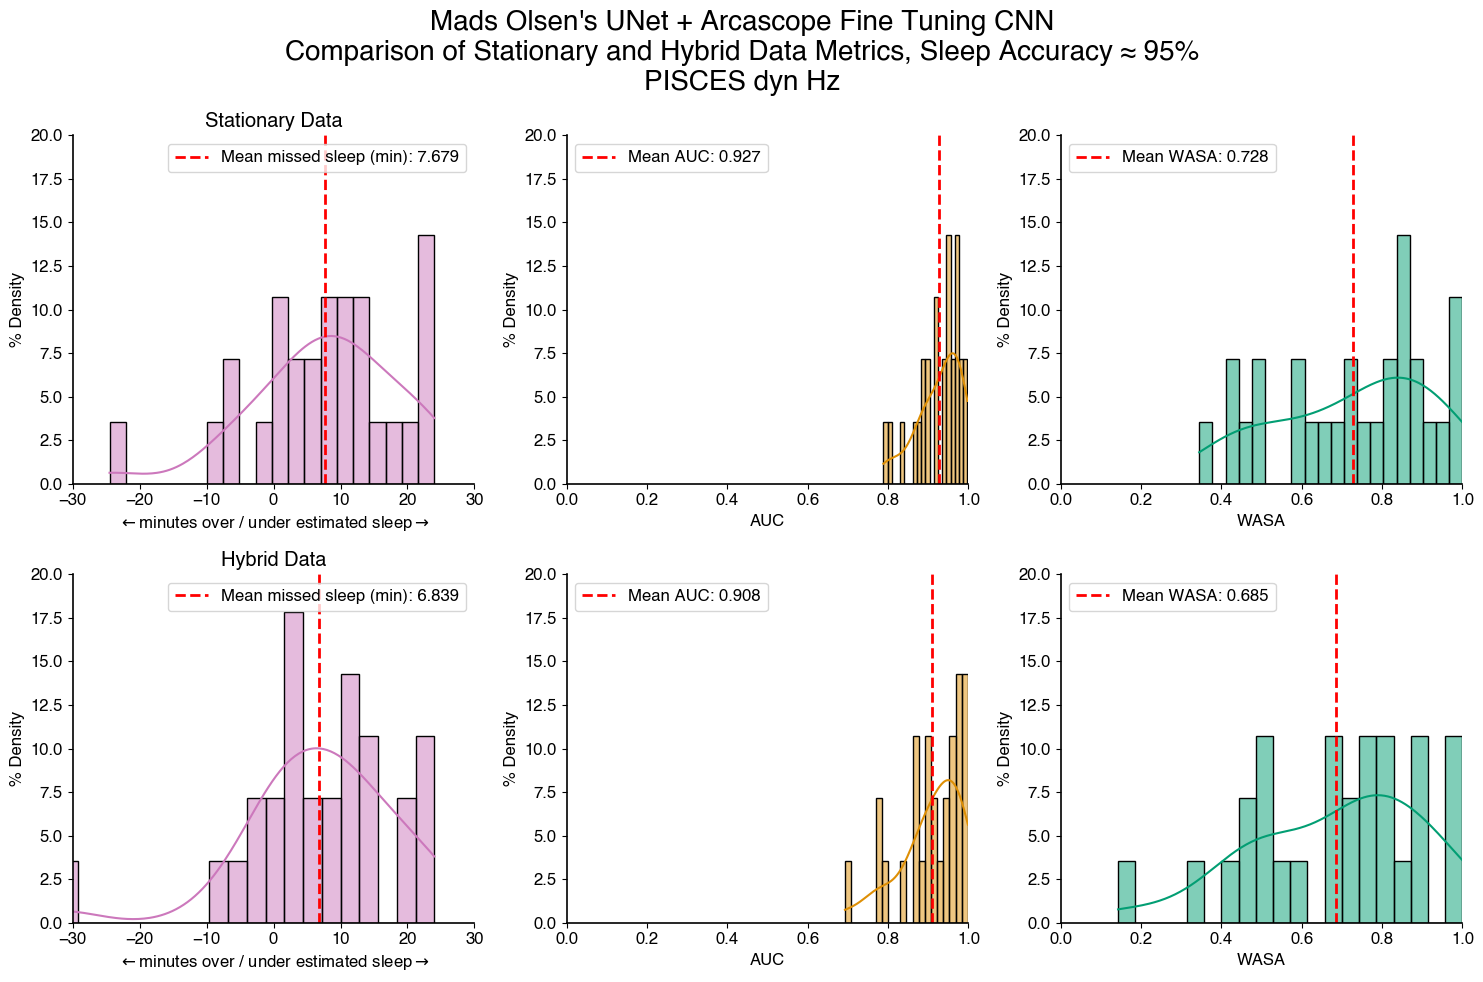

In [5]:

fig, axs = plt.subplots(2, 3, figsize=(15, 10))

cnn_evaluations_df = evaluations_df[evaluations_df[MODEL_COLUMN] == EXTRA_LOWER]
cnn_evaluations_df = cnn_evaluations_df[cnn_evaluations_df[SLEEP_ACCURACY_COLUMN] == WASA_SLEEP_PERCENT]
cnn_stationary = cnn_evaluations_df[cnn_evaluations_df[SCENARIO_COLUMN] == STATIONARY_LOWER]
cnn_hybrid = cnn_evaluations_df[cnn_evaluations_df[SCENARIO_COLUMN] == HYBRID_LOWER]

for ax in axs.flatten():
    ax.set_ylim(0, 20)

tri_plot_metrics(evaluations_df=cnn_stationary, axs=axs[0], axs_set_name=STATIONARY_SET_NAME,
                 wasa_column=WASA_COLUMN, accuracy_column=ACCURACY_COLUMN, auroc_column=AUROC_COLUMN)
tri_plot_metrics(cnn_hybrid, axs=axs[1], axs_set_name=HYBRID_SET_NAME,
                 wasa_column=WASA_COLUMN, accuracy_column=ACCURACY_COLUMN, auroc_column=AUROC_COLUMN)


fig.suptitle(f"Mads Olsen's UNet + Arcascope {EXTRA_LAYERS_NAME} CNN\n{SECOND_TITLE_LINE}\nPISCES {acc_hz_string} Hz", fontsize=20)

fig.tight_layout()
fig.savefig(DEFAULT_EVALUATION_DIR.joinpath(f"{EXTRA_LOWER}_triplot_{WASA_SLEEP_PERCENT}.png"), dpi=TRIPLOT_DPI, bbox_inches='tight')

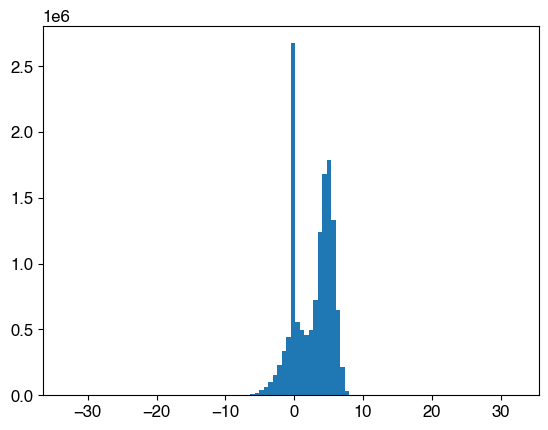

In [6]:
_  = plt.hist((walch_data_bundle.spectrogram.numpy() - hybrid_data_bundle.spectrogram.numpy()).ravel(), bins=100)

In [7]:
from collections import defaultdict
from pathlib import Path

import matplotlib.pyplot as plt

from analyses.NHRC.nhrc_utils.analysis import SCENARIOS


specgram_folder = Path('/Users/eric/Engineering/Work/pisces/data_sets/specgrams')

specgram_data = defaultdict(dict)

scenarios = SCENARIOS
print(scenarios)

for file in specgram_folder.joinpath('NSR').glob('*.npy'):
    scenario, subject_id = file.stem.split('_')[:2]
    specgram_data[scenario][subject_id] = np.squeeze(np.load(file, allow_pickle=True))

['stationary', 'hybrid']


In [8]:
specgram_data.keys()

dict_keys(['hybrid', 'stationary'])

In [9]:
keys = sorted(list(specgram_data['stationary'].keys()))

In [10]:
keys

['1066528',
 '1360686',
 '1449548',
 '1455390',
 '1818471',
 '2598705',
 '2638030',
 '3509524',
 '3997827',
 '4018081',
 '4314139',
 '4426783',
 '46343',
 '5132496',
 '5383425',
 '5498603',
 '5797046',
 '6220552',
 '759667',
 '781756',
 '8000685',
 '8173033',
 '8258170',
 '844359',
 '8530312',
 '8686948',
 '8692923',
 '9106476',
 '9618981',
 '9961348']

In [11]:
nsr_stationary = np.array([specgram_data['stationary'][subject_id] for subject_id in keys])
nsr_hybrid = np.array([specgram_data['hybrid'][subject_id] for subject_id in keys])

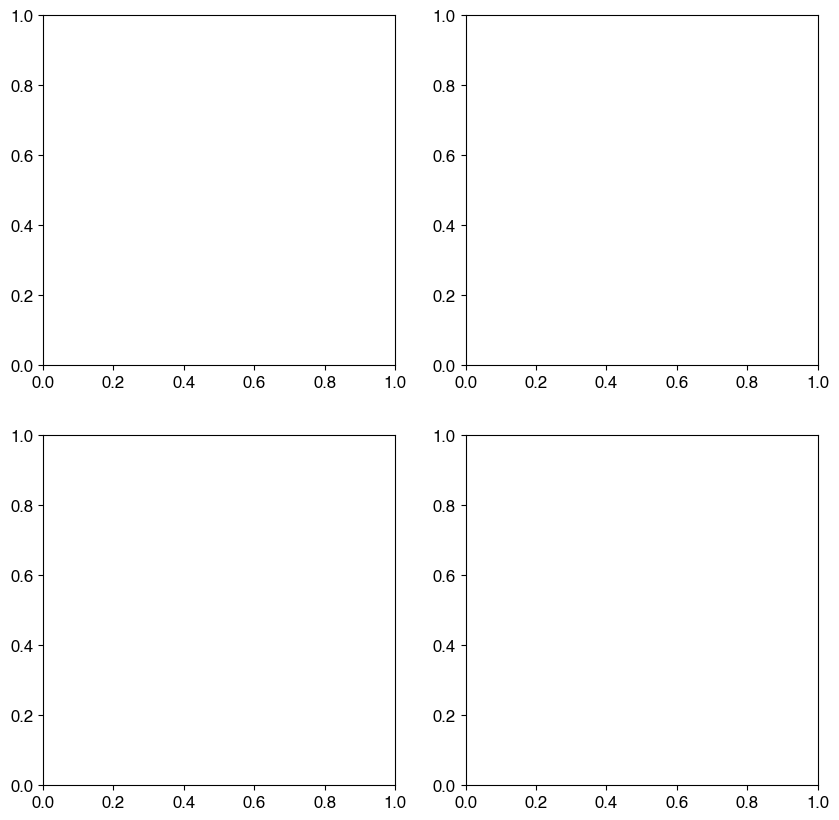

interactive(children=(FloatSlider(value=-15.0, description='vmin', max=0.0, min=-50.0, step=1.0), FloatSlider(…

<function __main__.update(vmin, vmax)>

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
datas = [
    [walch_data_bundle.spectrogram[0], hybrid_data_bundle.spectrogram[0]],
    [nsr_stationary[0], nsr_hybrid[0]]
]


def update(vmin, vmax):
    for row in range(2):
        for col in range(2):
            array = np.squeeze(datas[row][col])
            ax[row][col].imshow(array.T, aspect='auto', vmin=vmin, vmax=vmax)
            ax[0][col].set_title(['Stationary', 'Hybrid'][col])
        ax[row][0].set_ylabel(['Pisces', 'NSR'][row])

vmin_slider = widgets.FloatSlider(value=-15, min=-50, max=0, step=1, description='vmin')
vmax_slider = widgets.FloatSlider(value=20, min=0, max=50, step=1, description='vmax')

interact(update, vmin=vmin_slider, vmax=vmax_slider)

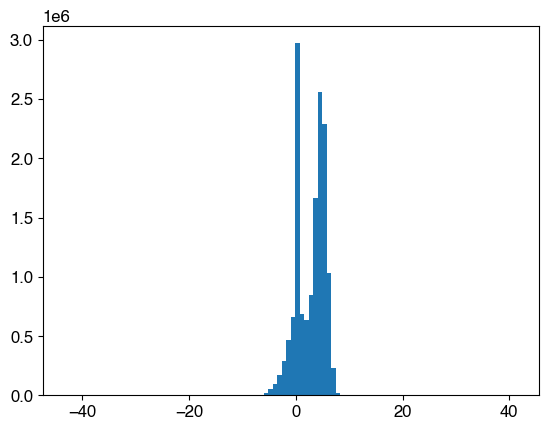

In [13]:
_  = plt.hist((nsr_stationary - nsr_hybrid).ravel(), bins=100)

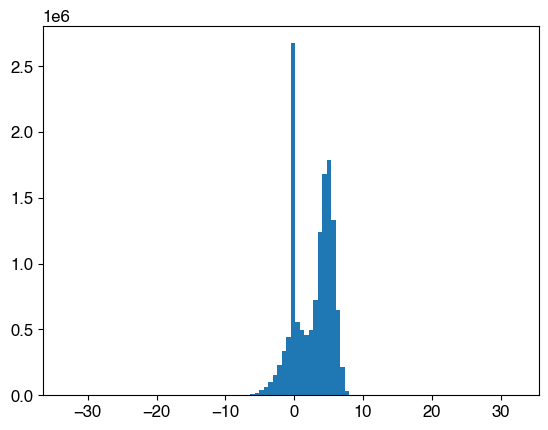

In [14]:
_  = plt.hist((walch_data_bundle.spectrogram.numpy() - hybrid_data_bundle.spectrogram.numpy()).ravel(), bins=100)

# Feed NSR exports into Pisces' MO evaluation loop

## Move NSR exports into bundles

In [15]:
missed_keys = 0
rev_sets_prepro = sets_prepro_data
for key in rev_sets_prepro.keys():
    pisces_prepro = rev_sets_prepro[key]
    nsr_prepro = specgram_data.get(key)

    if nsr_prepro is None:
        print("No NSR data for", key)
        continue

    print("Processing", key)

    for iden in pisces_prepro.keys():
        diff = rev_sets_prepro[key][iden]['spectrogram'] - nsr_prepro[iden]
        # print(f"Diff: [{diff.min()}, {diff.max()}], μ: {diff.mean()}")
        if iden not in nsr_prepro.keys():
            missed_keys += 1
            print("Missing", iden, "from NSR", key)
            continue
        rev_sets_prepro[key][iden]['spectrogram.backup'] = rev_sets_prepro[key][iden]['spectrogram']
        rev_sets_prepro[key][iden]['spectrogram'] = nsr_prepro[iden]
print(iden)
diff = rev_sets_prepro['stationary'][iden]['spectrogram'] - rev_sets_prepro['hybrid'][iden]['spectrogram']
print(f"Diff: [{diff.min()}, {diff.max()}], μ: {diff.mean()}")
    


Processing stationary
Processing hybrid
9961348
Diff: [-12.228557586669922, 7.592806816101074], μ: 1.9718892574310303


## Evaluations

In [16]:

import pandas as pd
import tensorflow as tf
from analyses.NHRC.nhrc_utils.analysis import DF_COLUMNS, WASA_SLEEP_ACCURACY, auroc_balaccuracy_wasa
from analyses.NHRC.nhrc_utils.model_definitions import cnn_pred_proba, lr_cnn_pred_proba, naive_pred_proba


# rev_sets = reverse_dicts(rev_sets_prepro)
rev_sets = sets_prepro_data

hybrid_preprocessed_data = rev_sets['hybrid']
walch_preprocessed_data = rev_sets['stationary']

walch_keys = list(walch_preprocessed_data.keys())

cnn_predictors = [
    tf.keras.models.load_model(f"/Users/eric/Engineering/Work/pisces/analyses/NHRC/evaluations/models/finetuning_{i}.keras")
    for i in walch_keys 
]

lr_predictors = [
    tf.keras.models.load_model(f"/Users/eric/Engineering/Work/pisces/analyses/NHRC/evaluations/models/lr_{i}.keras")
    for i in walch_keys 
]

model_types = ['naive', 'finetuning', 'lr']

hybrid_data_bundle = prepare_data(hybrid_preprocessed_data)
walch_data_bundle = prepare_data(walch_preprocessed_data)
evals = {s: 
    {m: [] for m in model_types} 
    for s in scenarios 
}

evaluations_df = pd.DataFrame(columns=DF_COLUMNS)

for test_idx in range(len(hybrid_preprocessed_data)):
    # extract inputs
    stationary_weights = walch_data_bundle.sample_weights[test_idx].numpy()
    stationary_labels = walch_data_bundle.true_labels[test_idx].numpy()
    stationary_labels_masked = np.where(stationary_weights, stationary_labels, 0)
    stationary_wldm_predictions = walch_data_bundle.mo_predictions[test_idx].numpy()
    stationary_lr_input = walch_data_bundle.activity[test_idx].numpy()

    hybrid_wldm_predictions = hybrid_data_bundle.mo_predictions[test_idx].numpy()
    hybrid_lr_input = hybrid_data_bundle.activity[test_idx].numpy()

    # z-normalize input data
    stationary_lr_input = (stationary_lr_input - np.mean(stationary_lr_input)) / np.std(stationary_lr_input)
    hybrid_lr_input = (hybrid_lr_input - np.mean(hybrid_lr_input)) / np.std(hybrid_lr_input)


    # process inputs into predictions
    stationary_naive = naive_pred_proba(stationary_wldm_predictions)
    stationary_lr = lr_cnn_pred_proba(
            lr_predictors[test_idx], 
            stationary_lr_input)
    stationary_cnn = cnn_pred_proba(
            cnn_predictors[test_idx], 
            stationary_wldm_predictions)
    hybrid_naive = naive_pred_proba(hybrid_wldm_predictions)
    hybrid_cnn = cnn_pred_proba(
            cnn_predictors[test_idx],
            hybrid_wldm_predictions)
    hybrid_lr = lr_cnn_pred_proba(
            lr_predictors[test_idx],
            hybrid_lr_input)
    
    eval_dict = {
        "stationary_naive": stationary_naive,
        "stationary_finetuning": stationary_cnn,
        "stationary_lr": stationary_lr,
        "hybrid_naive": hybrid_naive,
        "hybrid_finetuning": hybrid_cnn,
        "hybrid_lr": hybrid_lr
    }

    for model in model_types:
        for scenario in scenarios:
            evals[scenario][model] = auroc_balaccuracy_wasa(
                walch_keys[test_idx], 
                eval_dict[f'{scenario}_{model}'],
                stationary_weights,
                stationary_labels_masked,
                sleep_accuracy=WASA_SLEEP_ACCURACY)

    # now append each evaluation to the dataframe, labeled correctly
    evaluations_df = pd.concat([evaluations_df,
                                pd.DataFrame([
            [walch_keys[test_idx],
            scenario,
            model,
            *evals[scenario][model][i],
            int(100 * WASA_SLEEP_ACCURACY[i]),
            ]
            for scenario in scenarios for model in model_types
            for i in range(len(WASA_SLEEP_ACCURACY))
        ], columns=DF_COLUMNS
    )], ignore_index=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


/var/folders/h4/pg7xmblx74zbp2yhls4bc_mh0000gn/T/ipykernel_56946/3612455031.py:87: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  evaluations_df = pd.concat([evaluations_df,


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [17]:
from pisces.data_sets import DataSetObject

data_location = Path('/Users/eric/Engineering/Work/pisces/data_sets')

found_sets = DataSetObject.find_data_sets(data_location)
stationary_base = found_sets['walch_et_al']
hybrid_base = found_sets['hybrid_motion']

stationary_base.parse_data_sets()
hybrid_base.parse_data_sets()

In [18]:
s0_id = stationary_base.ids[0]

s0_acc = stationary_base.get_feature_data('accelerometer', s0_id)
h0_acc = hybrid_base.get_feature_data('accelerometer', s0_id)

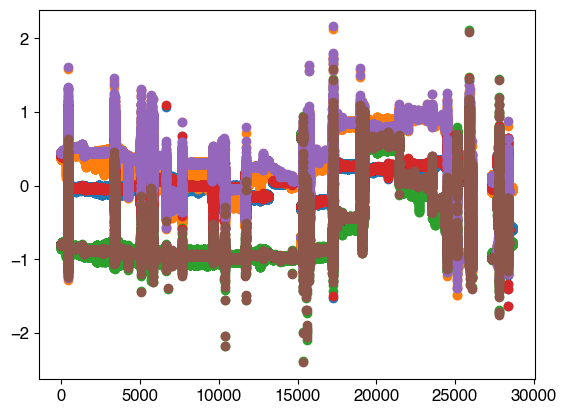

In [19]:
plt.plot(h0_acc[:, 0], h0_acc[:, 1:], 'o')
plt.plot(s0_acc[:, 0], s0_acc[:, 1:], 'o')

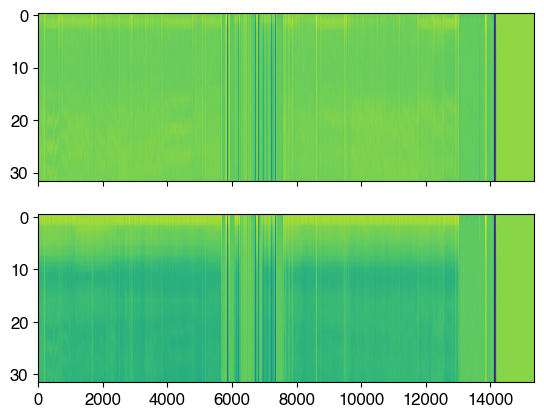

In [20]:
fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].imshow(walch_data_bundle.spectrogram[0].numpy().T, aspect='auto')
ax[1].imshow(hybrid_data_bundle.spectrogram[0].numpy().T, aspect='auto')

In [21]:
(walch_data_bundle.mo_predictions[0].numpy().T - hybrid_data_bundle.mo_predictions[0].numpy().T).std()

0.19171292

# It's the spectrograms
Specifically, the accelerometer resampling between NSR and pisces seems to be introducing differences! The Pisces-era eval loop below will discover the same outlier behavior as we saw in NSR.

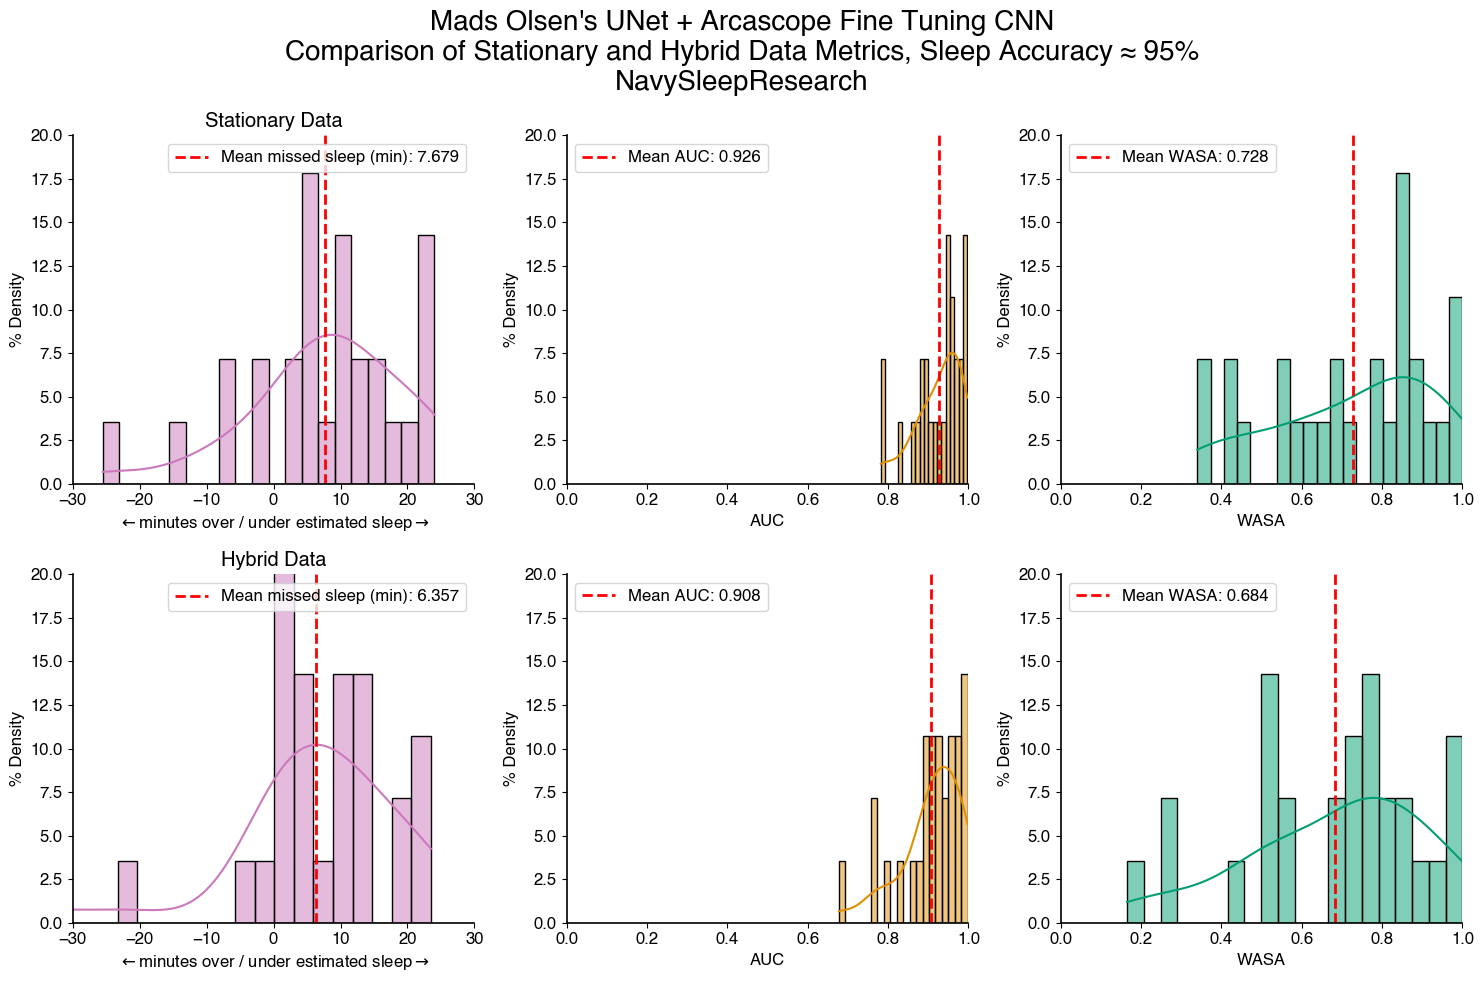

In [22]:

fig, axs = plt.subplots(2, 3, figsize=(15, 10))

cnn_evaluations_df = evaluations_df[evaluations_df[MODEL_COLUMN] == EXTRA_LOWER]
cnn_evaluations_df = cnn_evaluations_df[cnn_evaluations_df[SLEEP_ACCURACY_COLUMN] == WASA_SLEEP_PERCENT]
cnn_stationary = cnn_evaluations_df[cnn_evaluations_df[SCENARIO_COLUMN] == STATIONARY_LOWER]
cnn_hybrid = cnn_evaluations_df[cnn_evaluations_df[SCENARIO_COLUMN] == HYBRID_LOWER]

for ax in axs.flatten():
    ax.set_ylim(0, 20)

tri_plot_metrics(evaluations_df=cnn_stationary, axs=axs[0], axs_set_name=STATIONARY_SET_NAME,
                 wasa_column=WASA_COLUMN, accuracy_column=ACCURACY_COLUMN, auroc_column=AUROC_COLUMN)
tri_plot_metrics(cnn_hybrid, axs=axs[1], axs_set_name=HYBRID_SET_NAME,
                 wasa_column=WASA_COLUMN, accuracy_column=ACCURACY_COLUMN, auroc_column=AUROC_COLUMN)


fig.suptitle(f"Mads Olsen's UNet + Arcascope {EXTRA_LAYERS_NAME} CNN\n{SECOND_TITLE_LINE}\nNavySleepResearch", fontsize=20)

fig.tight_layout()
fig.savefig(DEFAULT_EVALUATION_DIR.joinpath(f"{EXTRA_LOWER}_triplot_{WASA_SLEEP_PERCENT}.png"), dpi=TRIPLOT_DPI, bbox_inches='tight')

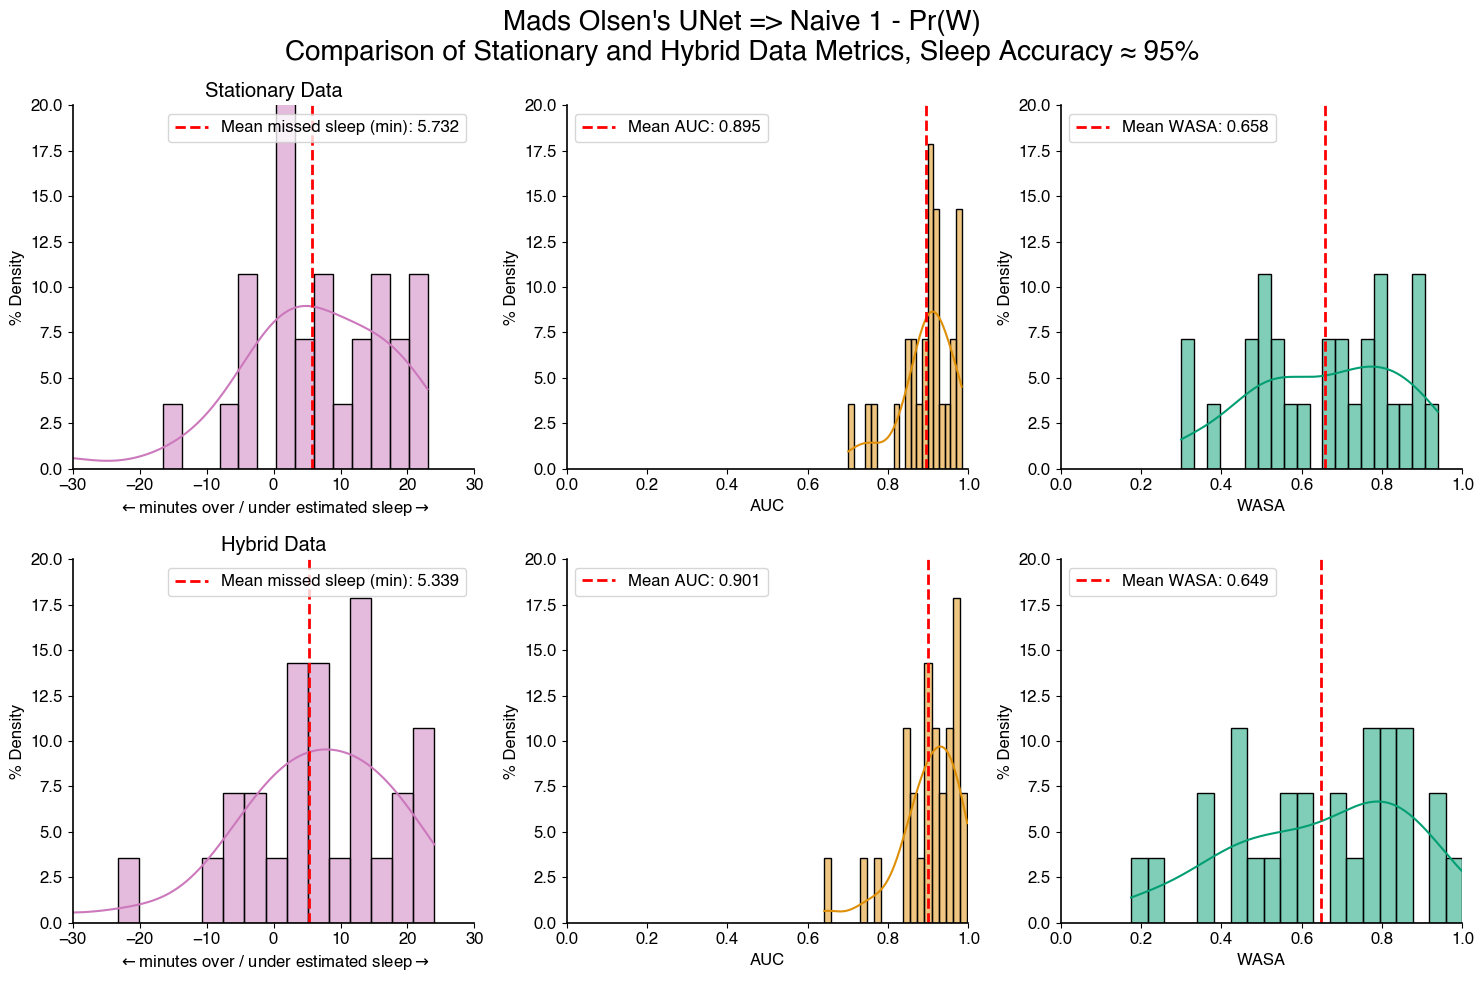

In [23]:


fig, axs = plt.subplots(2, 3, figsize=(15, 10))

naive_evaluations_df = evaluations_df[evaluations_df[MODEL_COLUMN] == NAIVE_LOWER]
naive_evaluations_df = naive_evaluations_df[naive_evaluations_df[SLEEP_ACCURACY_COLUMN] == WASA_SLEEP_PERCENT]
naive_stationary = naive_evaluations_df[naive_evaluations_df[SCENARIO_COLUMN] == STATIONARY_LOWER]
naive_hybrid = naive_evaluations_df[naive_evaluations_df[SCENARIO_COLUMN] == HYBRID_LOWER]

tri_plot_metrics(naive_stationary, axs=axs[0], axs_set_name=STATIONARY_SET_NAME, 
                 wasa_column=WASA_COLUMN, accuracy_column=ACCURACY_COLUMN, auroc_column=AUROC_COLUMN)
tri_plot_metrics(naive_hybrid, axs=axs[1], axs_set_name=HYBRID_SET_NAME, 
                 wasa_column=WASA_COLUMN, accuracy_column=ACCURACY_COLUMN, auroc_column=AUROC_COLUMN)
for ax in axs.flatten():
    ax.set_ylim(0, 20)

fig.suptitle(f"Mads Olsen's UNet => Naive 1 - Pr(W)\n{SECOND_TITLE_LINE}", fontsize=20)

fig.tight_layout()
fig.savefig(DEFAULT_EVALUATION_DIR.joinpath(f"{NAIVE_LOWER}_triplot_{WASA_SLEEP_PERCENT}.png"), dpi=TRIPLOT_DPI, bbox_inches='tight')

## Tri plot for logistic regression CNN

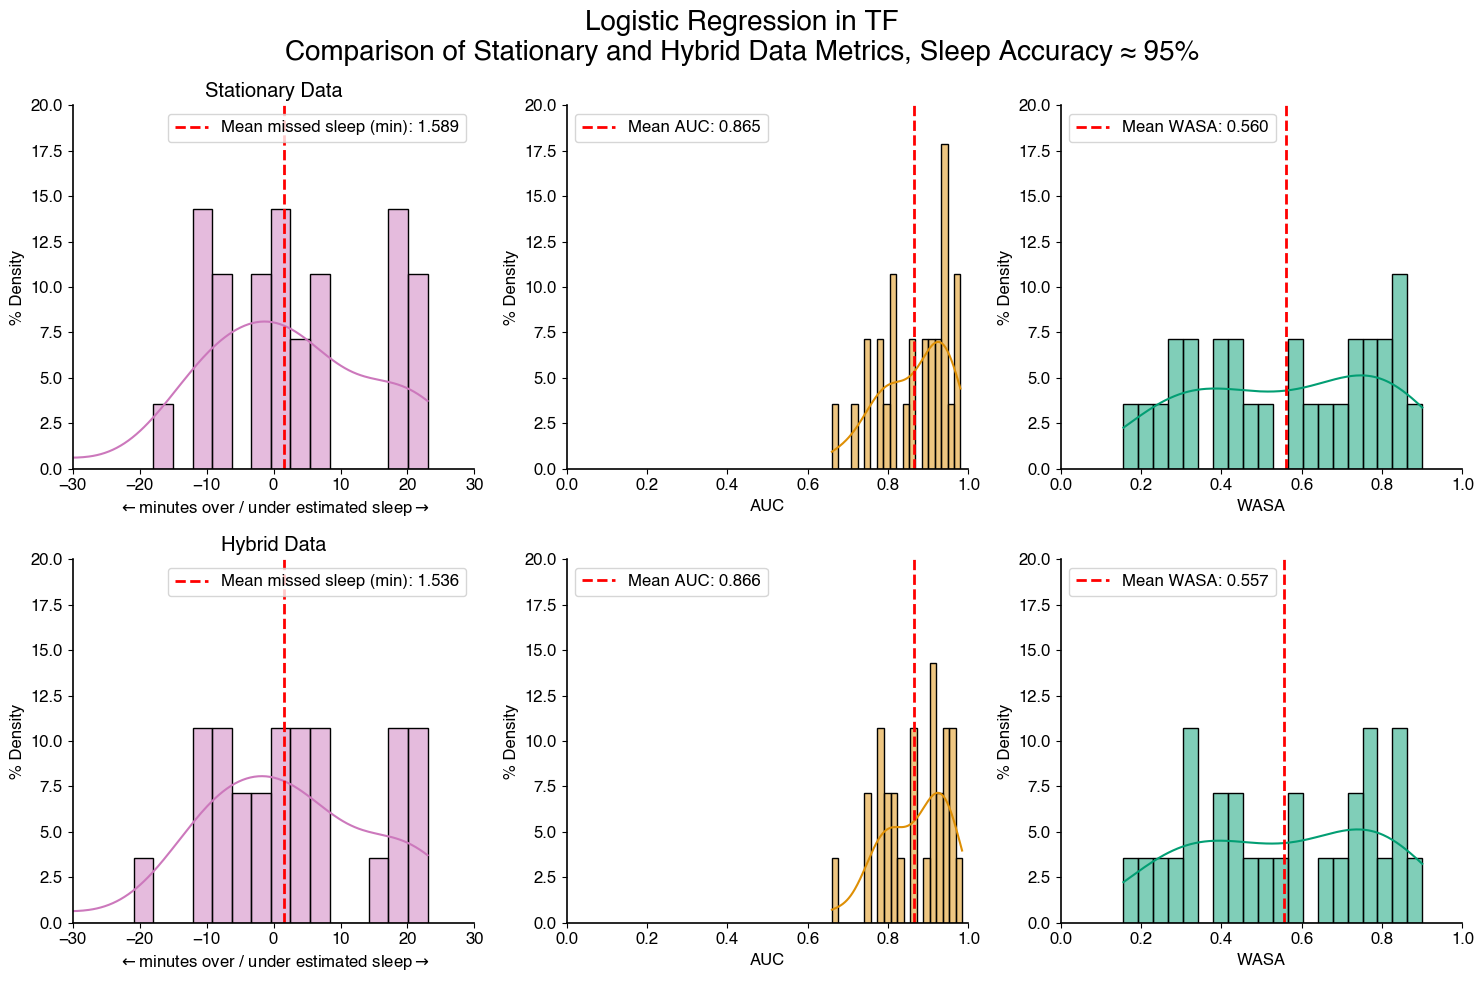

In [24]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

lr_evaluations_df = evaluations_df[evaluations_df[MODEL_COLUMN] == LR_LOWER]
lr_evaluations_df = lr_evaluations_df[lr_evaluations_df[SLEEP_ACCURACY_COLUMN] == WASA_SLEEP_PERCENT]
lr_stationary = lr_evaluations_df[lr_evaluations_df[SCENARIO_COLUMN] == STATIONARY_LOWER]
lr_hybrid = lr_evaluations_df[lr_evaluations_df[SCENARIO_COLUMN] == HYBRID_LOWER]

tri_plot_metrics(lr_stationary, axs=axs[0], axs_set_name=STATIONARY_SET_NAME,
                 wasa_column=WASA_COLUMN, accuracy_column=ACCURACY_COLUMN, auroc_column=AUROC_COLUMN)
tri_plot_metrics(lr_hybrid, axs=axs[1], axs_set_name=HYBRID_SET_NAME,
                 wasa_column=WASA_COLUMN, accuracy_column=ACCURACY_COLUMN, auroc_column=AUROC_COLUMN)

for ax in axs.flatten():
    ax.set_ylim(0, 20)

fig.suptitle(f"Logistic Regression in TF\n{SECOND_TITLE_LINE}", fontsize=20)

fig.tight_layout()
fig.savefig(DEFAULT_EVALUATION_DIR.joinpath(f"{LR_LOWER}_triplot_{WASA_SLEEP_PERCENT}.png"), dpi=TRIPLOT_DPI, bbox_inches='tight')